https://keras.io/examples/structured_data/movielens_recommendations_transformers/
https://arxiv.org/abs/1905.06874


# Sequential Recommender System

## 기존 추천 시스템의 한계
- 사용자의 sequential signal을 포착하지 못 함
- 주로 애견 용품을 구매하던 사용자인데, 최근에 핸드폰을 구입했다면?  
  핸드폰 악세서리를 구매할 확률이 높을 것
- 사용자가 주로 선택하던 아이템과 다른 아이템이 등장할 경우, 이에 대한 설명이 부족

## Sequential Recommender System
- 사용자의 선호도, 관심은 계속 변화한다
- 과거 행동에서 유의한 순차적인 패턴을 찾고, 최근 아이템에 더 집중하여 이를 기반으로 가장 선호할 다음 아이템을 추천
- RNN, CNN, Transformer 등의 기술들을 활용한 추천 시스템이 발전

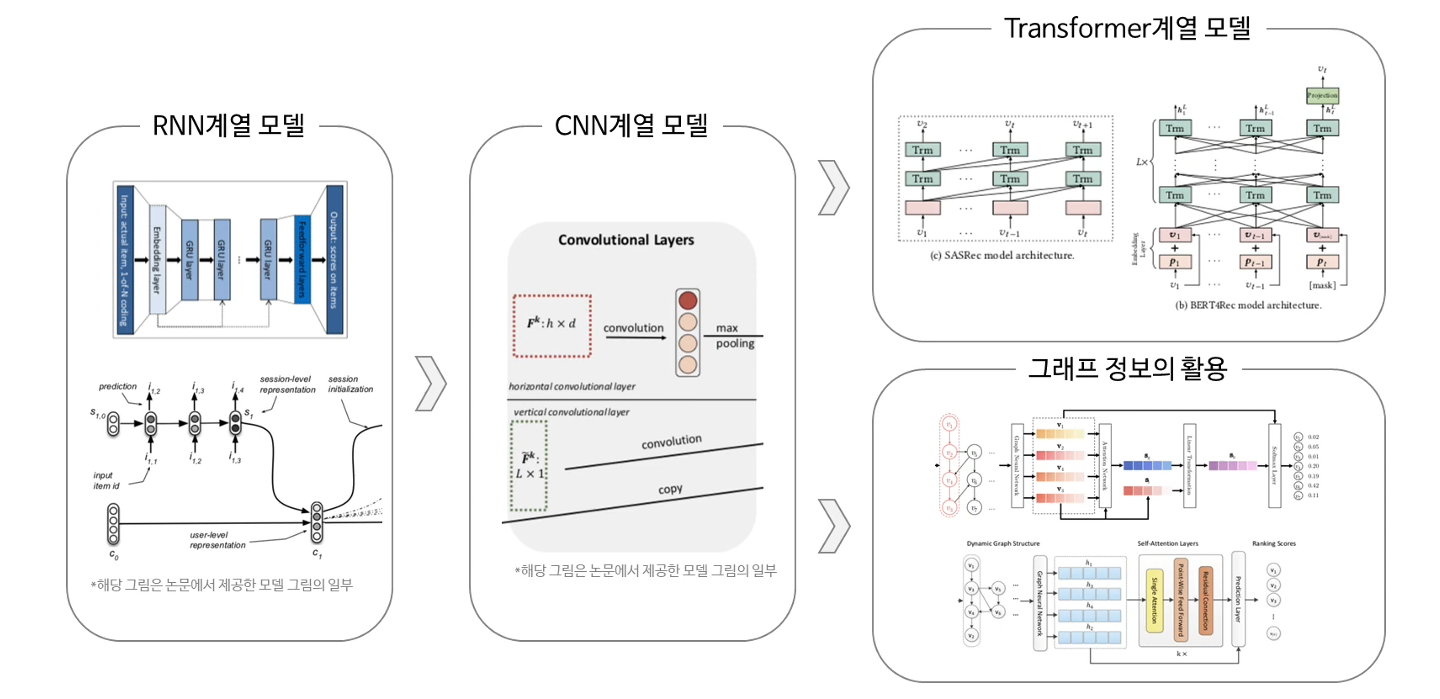

# BST model
## 개요
- Behavior Sequence Transformer for e-commerce Recommendation in Alibaba
- 2019, Alibaba의 Qiwei Chen 발표 논문
- User's behavior sequence가 transformer layer를 통과하게 하여 sequential signal을 포착

## BST 모델의 구성
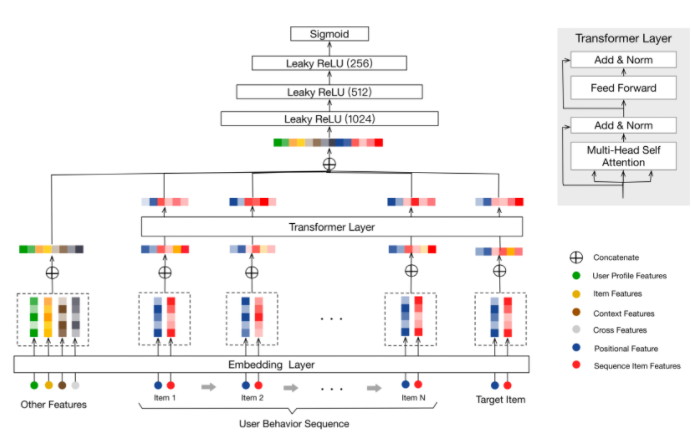

- **Embedding Layer**
  - 유저 정보(Other Features)
  - 유저가 구매한 아이템들 (User Behavior Sequence)
  - 타겟 아이템 (Target Item)

- **Transformer Layer**
  - User Behavior sequence(아이템 정보)는 transformer layer를 통과하면서 sequential한 정보에 가중치를 부여

- 각각의 시퀀스들을 concat
- Fully-connected layer를 통과하며 학습
- 유저가 타겟 아이템을 클릭할 지 여부를 출렧 (binary classification problem)

## Recommendation Systems 모델 성능 비교
https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m

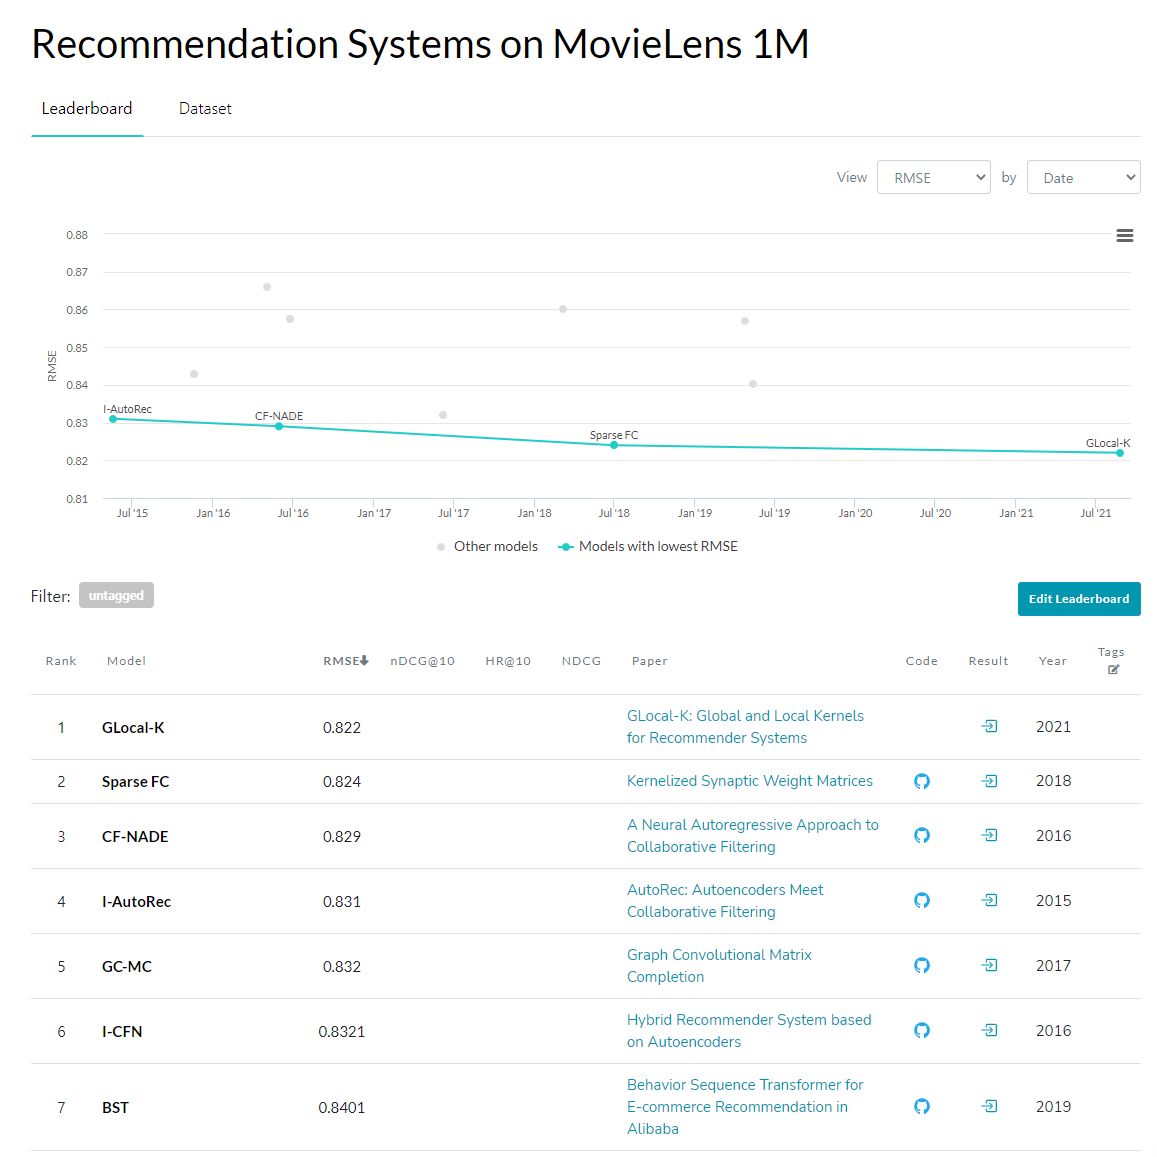


In [ ]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup

In [ ]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

In [ ]:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
)

ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
)

movies = pd.read_csv(
    "ml-1m/movies.dat", sep="::", names=["movie_id", "title", "genres"]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='pyth

In [ ]:
users.head()

,user_id,sex,age_group,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
users["user_id"] = users["user_id"].apply(lambda x: f"user_{x}")
users["age_group"] = users["age_group"].apply(lambda x: f"group_{x}")
users["occupation"] = users["occupation"].apply(lambda x: f"occupation_{x}")

movies["movie_id"] = movies["movie_id"].apply(lambda x: f"movie_{x}")

ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"movie_{x}")
ratings["user_id"] = ratings["user_id"].apply(lambda x: f"user_{x}")
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [ ]:
users.head()

,user_id,sex,age_group,occupation,zip_code
0,user_1,F,group_1,occupation_10,48067
1,user_2,M,group_56,occupation_16,70072
2,user_3,M,group_25,occupation_15,55117
3,user_4,M,group_45,occupation_7,02460
4,user_5,M,group_25,occupation_20,55455


In [ ]:
movies.head()

,movie_id,title,genres
0,movie_1,Toy Story (1995),Animation|Children's|Comedy
1,movie_2,Jumanji (1995),Adventure|Children's|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama
4,movie_5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,user_1,movie_1193,5.0,978300760
1,user_1,movie_661,3.0,978302109
2,user_1,movie_914,3.0,978301968
3,user_1,movie_3408,4.0,978300275
4,user_1,movie_2355,5.0,978824291


In [ ]:
len(users), len(movies), len(ratings)

(6040, 3883, 1000209)

In [ ]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

for genre in genres:
    movies[genre] = movies["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )

In [ ]:
ratings_group = ratings.sort_values(by=["unix_timestamp"]).groupby("user_id")

ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list)),
    }
)

In [ ]:
sequence_length = 4
step_size = 2


def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences


ratings_data.movie_ids = ratings_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

del ratings_data["timestamps"]

In [ ]:
ratings_data.movie_ids

0       [[movie_3186, movie_1721, movie_1270, movie_10...
1       [[movie_597, movie_858, movie_743, movie_1210]...
2       [[movie_260, movie_1676, movie_1198, movie_541...
3       [[movie_971, movie_260, movie_2990, movie_2973...
4       [[movie_1198, movie_1617, movie_2885, movie_39...
                              ...                        
6035    [[movie_1894, movie_260, movie_247, movie_433]...
6036    [[movie_1347, movie_2146, movie_1961, movie_27...
6037    [[movie_1196, movie_2082, movie_3247, movie_24...
6038    [[movie_2266, movie_1264, movie_1097, movie_16...
6039    [[movie_1196, movie_1015, movie_1600, movie_10...
Name: movie_ids, Length: 6040, dtype: object

In [ ]:
ratings_data.ratings

0       [[4.0, 4.0, 5.0, 5.0], [5.0, 5.0, 3.0, 5.0], [...
1       [[4.0, 3.0, 3.0, 4.0], [3.0, 4.0, 4.0, 5.0], [...
2       [[4.0, 3.0, 4.0, 3.0], [4.0, 3.0, 4.0, 3.0], [...
3       [[4.0, 5.0, 4.0, 3.0], [4.0, 3.0, 5.0, 5.0], [...
4       [[4.0, 4.0, 4.0, 2.0], [4.0, 2.0, 2.0, 1.0], [...
                              ...                        
6035    [[2.0, 4.0, 5.0, 3.0], [5.0, 3.0, 3.0, 4.0], [...
6036    [[4.0, 3.0, 5.0, 3.0], [5.0, 3.0, 5.0, 5.0], [...
6037    [[4.0, 3.0, 3.0, 3.0], [3.0, 3.0, 2.0, 5.0], [...
6038    [[3.0, 4.0, 5.0, 5.0], [5.0, 5.0, 4.0, 3.0], [...
6039    [[5.0, 3.0, 1.0, 4.0], [1.0, 4.0, 2.0, 4.0], [...
Name: ratings, Length: 6040, dtype: object

In [ ]:
ratings_data.head()

,user_id,movie_ids,ratings
0,user_1,"[[movie_3186, movie_1721, movie_1270, movie_10...","[[4.0, 4.0, 5.0, 5.0], [5.0, 5.0, 3.0, 5.0], [..."
1,user_10,"[[movie_597, movie_858, movie_743, movie_1210]...","[[4.0, 3.0, 3.0, 4.0], [3.0, 4.0, 4.0, 5.0], [..."
2,user_100,"[[movie_260, movie_1676, movie_1198, movie_541...","[[4.0, 3.0, 4.0, 3.0], [4.0, 3.0, 4.0, 3.0], [..."
3,user_1000,"[[movie_971, movie_260, movie_2990, movie_2973...","[[4.0, 5.0, 4.0, 3.0], [4.0, 3.0, 5.0, 5.0], [..."
4,user_1001,"[[movie_1198, movie_1617, movie_2885, movie_39...","[[4.0, 4.0, 4.0, 2.0], [4.0, 2.0, 2.0, 1.0], [..."


In [ ]:
ratings_data.movie_ids[0]

[['movie_3186', 'movie_1721', 'movie_1270', 'movie_1022'],
 ['movie_1270', 'movie_1022', 'movie_2340', 'movie_1836'],
 ['movie_2340', 'movie_1836', 'movie_3408', 'movie_1207'],
 ['movie_3408', 'movie_1207', 'movie_2804', 'movie_260'],
 ['movie_2804', 'movie_260', 'movie_720', 'movie_1193'],
 ['movie_720', 'movie_1193', 'movie_919', 'movie_608'],
 ['movie_919', 'movie_608', 'movie_2692', 'movie_1961'],
 ['movie_2692', 'movie_1961', 'movie_2028', 'movie_3105'],
 ['movie_2028', 'movie_3105', 'movie_938', 'movie_1035'],
 ['movie_938', 'movie_1035', 'movie_1962', 'movie_1028'],
 ['movie_1962', 'movie_1028', 'movie_2018', 'movie_150'],
 ['movie_2018', 'movie_150', 'movie_1097', 'movie_914'],
 ['movie_1097', 'movie_914', 'movie_1287', 'movie_2797'],
 ['movie_1287', 'movie_2797', 'movie_1246', 'movie_2762'],
 ['movie_1246', 'movie_2762', 'movie_661', 'movie_2918'],
 ['movie_661', 'movie_2918', 'movie_531', 'movie_3114'],
 ['movie_531', 'movie_3114', 'movie_2791', 'movie_1029'],
 ['movie_2791',

In [ ]:
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True
)
ratings_data_rating = ratings_data[["ratings"]].explode("ratings", ignore_index=True)
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
ratings_data_transformed = ratings_data_transformed.join(
    users.set_index("user_id"), on="user_id"
)
ratings_data_transformed.movie_ids = ratings_data_transformed.movie_ids.apply(
    lambda x: ",".join(x)
)
ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply(
    lambda x: ",".join([str(v) for v in x])
)

del ratings_data_transformed["zip_code"]

ratings_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids", "ratings": "sequence_ratings"},
    inplace=True,
)

In [ ]:
ratings_data_movies

,user_id,movie_ids
0,user_1,"[movie_3186, movie_1721, movie_1270, movie_1022]"
1,user_1,"[movie_1270, movie_1022, movie_2340, movie_1836]"
2,user_1,"[movie_2340, movie_1836, movie_3408, movie_1207]"
3,user_1,"[movie_3408, movie_1207, movie_2804, movie_260]"
4,user_1,"[movie_2804, movie_260, movie_720, movie_1193]"
...,...,...
498618,user_999,"[movie_2676, movie_2540, movie_1363, movie_765]"
498619,user_999,"[movie_1363, movie_765, movie_3565, movie_1410]"
498620,user_999,"[movie_3565, movie_1410, movie_2269, movie_2504]"
498621,user_999,"[movie_2269, movie_2504, movie_455, movie_193]"


In [ ]:
ratings_data_transformed

,user_id,sequence_movie_ids,sequence_ratings,sex,age_group,occupation
0,user_1,"movie_3186,movie_1721,movie_1270,movie_1022","4.0,4.0,5.0,5.0",F,group_1,occupation_10
1,user_1,"movie_1270,movie_1022,movie_2340,movie_1836","5.0,5.0,3.0,5.0",F,group_1,occupation_10
2,user_1,"movie_2340,movie_1836,movie_3408,movie_1207","3.0,5.0,4.0,4.0",F,group_1,occupation_10
3,user_1,"movie_3408,movie_1207,movie_2804,movie_260","4.0,4.0,5.0,4.0",F,group_1,occupation_10
4,user_1,"movie_2804,movie_260,movie_720,movie_1193","5.0,4.0,3.0,5.0",F,group_1,occupation_10
...,...,...,...,...,...,...
498618,user_999,"movie_2676,movie_2540,movie_1363,movie_765","3.0,2.0,3.0,3.0",M,group_25,occupation_15
498619,user_999,"movie_1363,movie_765,movie_3565,movie_1410","3.0,3.0,4.0,2.0",M,group_25,occupation_15
498620,user_999,"movie_3565,movie_1410,movie_2269,movie_2504","4.0,2.0,3.0,3.0",M,group_25,occupation_15
498621,user_999,"movie_2269,movie_2504,movie_455,movie_193","3.0,3.0,2.0,2.0",M,group_25,occupation_15


In [ ]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("test_data.csv", index=False, sep="|", header=False)

In [ ]:
train_data

,user_id,sequence_movie_ids,sequence_ratings,sex,age_group,occupation
0,user_1,"movie_3186,movie_1721,movie_1270,movie_1022","4.0,4.0,5.0,5.0",F,group_1,occupation_10
1,user_1,"movie_1270,movie_1022,movie_2340,movie_1836","5.0,5.0,3.0,5.0",F,group_1,occupation_10
3,user_1,"movie_3408,movie_1207,movie_2804,movie_260","4.0,4.0,5.0,4.0",F,group_1,occupation_10
4,user_1,"movie_2804,movie_260,movie_720,movie_1193","5.0,4.0,3.0,5.0",F,group_1,occupation_10
5,user_1,"movie_720,movie_1193,movie_919,movie_608","3.0,5.0,4.0,4.0",F,group_1,occupation_10
...,...,...,...,...,...,...
498617,user_999,"movie_2264,movie_1959,movie_2676,movie_2540","2.0,1.0,3.0,2.0",M,group_25,occupation_15
498618,user_999,"movie_2676,movie_2540,movie_1363,movie_765","3.0,2.0,3.0,3.0",M,group_25,occupation_15
498619,user_999,"movie_1363,movie_765,movie_3565,movie_1410","3.0,3.0,4.0,2.0",M,group_25,occupation_15
498621,user_999,"movie_2269,movie_2504,movie_455,movie_193","3.0,3.0,2.0,2.0",M,group_25,occupation_15


In [ ]:
test_data

,user_id,sequence_movie_ids,sequence_ratings,sex,age_group,occupation
2,user_1,"movie_2340,movie_1836,movie_3408,movie_1207","3.0,5.0,4.0,4.0",F,group_1,occupation_10
7,user_1,"movie_2692,movie_1961,movie_2028,movie_3105","4.0,5.0,5.0,5.0",F,group_1,occupation_10
13,user_1,"movie_1287,movie_2797,movie_1246,movie_2762","5.0,4.0,4.0,4.0",F,group_1,occupation_10
18,user_1,"movie_2321,movie_1197,movie_594,movie_2398","3.0,3.0,4.0,4.0",F,group_1,occupation_10
19,user_1,"movie_594,movie_2398,movie_1545,movie_527","4.0,4.0,4.0,5.0",F,group_1,occupation_10
...,...,...,...,...,...,...
498591,user_999,"movie_3259,movie_1124,movie_1183,movie_271","3.0,3.0,2.0,3.0",M,group_25,occupation_15
498597,user_999,"movie_3791,movie_225,movie_507,movie_3173","4.0,4.0,3.0,3.0",M,group_25,occupation_15
498598,user_999,"movie_507,movie_3173,movie_3176,movie_354","3.0,3.0,4.0,4.0",M,group_25,occupation_15
498613,user_999,"movie_207,movie_79,movie_2875,movie_2316","4.0,3.0,4.0,3.0",M,group_25,occupation_15


In [ ]:
CSV_HEADER = list(ratings_data_transformed.columns)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(users.user_id.unique()),
    "movie_id": list(movies.movie_id.unique()),
    "sex": list(users.sex.unique()),
    "age_group": list(users.age_group.unique()),
    "occupation": list(users.occupation.unique()),
}

USER_FEATURES = ["sex", "age_group", "occupation"]

MOVIE_FEATURES = ["genres"]

In [ ]:
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        movie_ids_string = features["sequence_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_string, ",").to_tensor()

        # The last movie id in the sequence is the target movie.
        features["target_movie_id"] = sequence_movie_ids[:, -1]
        features["sequence_movie_ids"] = sequence_movie_ids[:, :-1]

        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]

        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset

In [ ]:
def create_model_inputs():
    return {
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "sequence_movie_ids": layers.Input(
            name="sequence_movie_ids", shape=(sequence_length - 1,), dtype=tf.string
        ),
        "target_movie_id": layers.Input(
            name="target_movie_id", shape=(1,), dtype=tf.string
        ),
        "sequence_ratings": layers.Input(
            name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32
        ),
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
    }

In [ ]:
def encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True,
):

    encoded_transformer_features = []
    encoded_other_features = []

    other_feature_names = []
    if include_user_id:
        other_feature_names.append("user_id")
    if include_user_features:
        other_feature_names.extend(USER_FEATURES)

    ## Encode user features
    for feature_name in other_feature_names:
        # Convert the string input values into integer indices.
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature_name]
        )
        # Compute embedding dimensions
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions.
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        # Convert the index values to embedding representations.
        encoded_other_features.append(embedding_encoder(idx))

    ## Create a single embedding vector for the user features
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## Create a movie embedding encoder
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    movie_index_lookup = StringLookup(
        vocabulary=movie_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="movie_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    movie_embedding_encoder = layers.Embedding(
        input_dim=len(movie_vocabulary),
        output_dim=movie_embedding_dims,
        name=f"movie_embedding",
    )
    # Create a vector lookup for movie genres.
    genre_vectors = movies[genres].to_numpy()
    movie_genres_lookup = layers.Embedding(
        input_dim=genre_vectors.shape[0],
        output_dim=genre_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),
        trainable=False,
        name="genres_vector",
    )
    # Create a processing layer for genres.
    movie_embedding_processor = layers.Dense(
        units=movie_embedding_dims,
        activation="relu",
        name="process_movie_embedding_with_genres",
    )

    ## Define a function to encode a given movie id.
    def encode_movie(movie_id):
        # Convert the string input values into integer indices.
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(
                layers.concatenate([movie_embedding, movie_genres_vector])
            )
        return encoded_movie

    ## Encoding target_movie_id
    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = encode_movie(target_movie_id)

    ## Encoding sequence movie_ids.
    sequence_movies_ids = inputs["sequence_movie_ids"]
    encoded_sequence_movies = encode_movie(sequence_movies_ids)
    # Create positional embedding.
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=movie_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1)
    # Add the positional encoding to the movie encodings and multiply them by rating.
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_movies + encodded_positions), sequence_ratings]
    )

    # Construct the transformer inputs.
    for encoded_movie in tf.unstack(
        encoded_sequence_movies_with_poistion_and_rating, axis=1
    ):
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))
    encoded_transformer_features.append(encoded_target_movie)

    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1
    )

    return encoded_transformer_features, encoded_other_features

In [ ]:
include_user_id = False
include_user_features = False
include_movie_features = False

hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3


def create_model():
    inputs = create_model_inputs()
    transformer_features, other_features = encode_input_features(
        inputs, include_user_id, include_user_features, include_movie_features
    )

    # Create a multi-headed attention layer.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
    )(transformer_features, transformer_features)

    # Transformer block.
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)

    # Included the other features.
    if other_features is not None:
        features = layers.concatenate(
            [features, layers.Reshape([other_features.shape[-1]])(other_features)]
        )

    # Fully-connected layers.
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = create_model()

In [ ]:
# Compile the model.
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()],
)

# Read the training data.
train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Fit the model with the training data.
model.fit(train_dataset, epochs=5)

# Read the test data.
test_dataset = get_dataset_from_csv("test_data.csv", batch_size=265)

# Evaluate the model on the test data.
_, rmse = model.evaluate(test_dataset, verbose=0)
print(f"Test MAE: {round(rmse, 3)}")

Epoch 1/5
1600/1600 [==============================] - 35s 18ms/step - loss: 1.2309 - mean_absolute_error: 0.8827
Epoch 2/5
1600/1600 [==============================] - 29s 18ms/step - loss: 1.0077 - mean_absolute_error: 0.8009
Epoch 3/5
1600/1600 [==============================] - 30s 19ms/step - loss: 0.9524 - mean_absolute_error: 0.7782
Epoch 4/5
1600/1600 [==============================] - 31s 19ms/step - loss: 0.9227 - mean_absolute_error: 0.7652
Epoch 5/5
1600/1600 [==============================] - 32s 20ms/step - loss: 0.9040 - mean_absolute_error: 0.7570
Test MAE: 0.769


In [ ]:
train_dataset

<MapDataset shapes: (OrderedDict([(user_id, (None,)), (sequence_movie_ids, (None, None)), (sequence_ratings, (None, None)), (sex, (None,)), (age_group, (None,)), (occupation, (None,)), (target_movie_id, (None,))]), (None,)), types: (OrderedDict([(user_id, tf.string), (sequence_movie_ids, tf.string), (sequence_ratings, tf.float32), (sex, tf.string), (age_group, tf.string), (occupation, tf.string), (target_movie_id, tf.string)]), tf.float32)>

In [ ]:
test_dataset

<MapDataset shapes: (OrderedDict([(user_id, (None,)), (sequence_movie_ids, (None, None)), (sequence_ratings, (None, None)), (sex, (None,)), (age_group, (None,)), (occupation, (None,)), (target_movie_id, (None,))]), (None,)), types: (OrderedDict([(user_id, tf.string), (sequence_movie_ids, tf.string), (sequence_ratings, tf.float32), (sex, tf.string), (age_group, tf.string), (occupation, tf.string), (target_movie_id, tf.string)]), tf.float32)>

In [ ]:
result = model.predict(test_dataset)
len(result)

74802

In [ ]:
result[0]

array([4.281157], dtype=float32)

In [ ]:
df = train_dataset.as_dataframe(ds.take(10), ds_info)

AttributeError: ignored

In [ ]:
i = 1
for e in test_dataset:
  print(e)
  break


(OrderedDict([('user_id', <tf.Tensor: shape=(265,), dtype=string, numpy=
array([b'user_1', b'user_1', b'user_1', b'user_1', b'user_1', b'user_1',
       b'user_10', b'user_10', b'user_10', b'user_10', b'user_10',
       b'user_10', b'user_10', b'user_10', b'user_10', b'user_10',
       b'user_10', b'user_10', b'user_10', b'user_10', b'user_10',
       b'user_10', b'user_10', b'user_10', b'user_10', b'user_10',
       b'user_10', b'user_10', b'user_10', b'user_10', b'user_10',
       b'user_10', b'user_10', b'user_10', b'user_10', b'user_10',
       b'user_10', b'user_100', b'user_100', b'user_100', b'user_100',
       b'user_100', b'user_100', b'user_1000', b'user_1000', b'user_1000',
       b'user_1000', b'user_1000', b'user_1001', b'user_1001',
       b'user_1001', b'user_1001', b'user_1001', b'user_1001',
       b'user_1001', b'user_1001', b'user_1001', b'user_1001',
       b'user_1001', b'user_1001', b'user_1001', b'user_1001',
       b'user_1001', b'user_1001', b'user_1001', b'use

In [ ]:
test2 = test_data[0:5]
test2.to_csv("test2.csv", index=False, sep="|", header=False)
test2_dataset = get_dataset_from_csv("test2.csv", batch_size=265)

In [ ]:
test2

,user_id,sequence_movie_ids,sequence_ratings,sex,age_group,occupation
2,user_1,"movie_2340,movie_1836,movie_3408,movie_1207","3.0,5.0,4.0,4.0",F,group_1,occupation_10
7,user_1,"movie_2692,movie_1961,movie_2028,movie_3105","4.0,5.0,5.0,5.0",F,group_1,occupation_10
13,user_1,"movie_1287,movie_2797,movie_1246,movie_2762","5.0,4.0,4.0,4.0",F,group_1,occupation_10
18,user_1,"movie_2321,movie_1197,movie_594,movie_2398","3.0,3.0,4.0,4.0",F,group_1,occupation_10
19,user_1,"movie_594,movie_2398,movie_1545,movie_527","4.0,4.0,4.0,5.0",F,group_1,occupation_10


In [ ]:
for e in test2_dataset:
  print(e)
  break

(OrderedDict([('user_id', <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'user_1', b'user_1', b'user_1', b'user_1', b'user_1'],
      dtype=object)>), ('sequence_movie_ids', <tf.Tensor: shape=(5, 3), dtype=string, numpy=
array([[b'movie_2340', b'movie_1836', b'movie_3408'],
       [b'movie_2692', b'movie_1961', b'movie_2028'],
       [b'movie_1287', b'movie_2797', b'movie_1246'],
       [b'movie_2321', b'movie_1197', b'movie_594'],
       [b'movie_594', b'movie_2398', b'movie_1545']], dtype=object)>), ('sequence_ratings', <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[3., 5., 4.],
       [4., 5., 5.],
       [5., 4., 4.],
       [3., 3., 4.],
       [4., 4., 4.]], dtype=float32)>), ('sex', <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'F', b'F', b'F', b'F', b'F'], dtype=object)>), ('age_group', <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'group_1', b'group_1', b'group_1', b'group_1', b'group_1'],
      dtype=object)>), ('occupation', <tf.Tensor: shape=(5,)

In [ ]:
model.predict(test2_dataset)

array([[4.281157 ],
       [3.9817412],
       [4.1596456],
       [3.9985752],
       [4.1067   ]], dtype=float32)

In [ ]:
test3 = test2.copy()
test3.sequence_ratings[2] = str("3,1,4,100")
test3

,user_id,sequence_movie_ids,sequence_ratings,sex,age_group,occupation
2,user_1,"movie_2340,movie_1836,movie_3408,movie_1207","3,1,4,100",F,group_1,occupation_10
7,user_1,"movie_2692,movie_1961,movie_2028,movie_3105","4.0,5.0,5.0,5.0",F,group_1,occupation_10
13,user_1,"movie_1287,movie_2797,movie_1246,movie_2762","5.0,4.0,4.0,4.0",F,group_1,occupation_10
18,user_1,"movie_2321,movie_1197,movie_594,movie_2398","3.0,3.0,4.0,4.0",F,group_1,occupation_10
19,user_1,"movie_594,movie_2398,movie_1545,movie_527","4.0,4.0,4.0,5.0",F,group_1,occupation_10


In [ ]:
test3.to_csv("test3.csv", index=False, sep="|", header=False)
test3_dataset = get_dataset_from_csv("test3.csv", batch_size=265)
model.predict(test3_dataset)

array([[4.0679283],
       [3.9817412],
       [4.1596456],
       [3.9985752],
       [4.1067   ]], dtype=float32)